# Forward dynamics of infection on Zachary’s karate club data
Comparison with Fig. 2 in *Ortega et. al*, [Dynamics of epidemics from cavity master equations: Susceptible-infectious-susceptible models](https://doi.org/10.1103/PhysRevE.105.024308)

In [401]:
using MatrixProductBP, MatrixProductBP.Models
using IndexedGraphs, DelimitedFiles, Plots, Statistics
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
import Measurements: value
using JLD2;

In [3]:
# read matrix of contacts, found at http://konect.cc/networks/ucidata-zachary/
A = readdlm("karate.txt", Bool)
g = IndexedGraph(A);

In [424]:
N = nv(g)  # number of individuals
T = 50     # final time
ΔT = 0.2   # discretization
λ = 0.1    # prob. of transmission
ρ = 0.05   # prob. of recovery

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ*ΔT, ρ*ΔT, floor(Int, T/ΔT))

# prob. of being infected at time zero
for i in 1:N
   if i == 1
        sis.ϕ[i][1] .*= [0.0, 1.0]   # node 1 is infected at time zero
    else
        sis.ϕ[i][1] .*= [1.0, 0.0]   # all other nodes start as susceptible
    end
end

# set up MPBP computation
bp = mpbp(sis)
cb = CB_BP(bp);

In [425]:
svd_trunc = TruncBond(5)   # maximum matrix size for SVD-based truncation
maxiter = 100
tol = 1e-4

# run MPBP
iters, cb = iterate!(bp; cb, svd_trunc, maxiter, tol);

Running MPBP: iter 10 	 Time: 0:18:02
  Δ:                6.040423237073232e-5
  SVD Matrix size:  5

In [426]:
if iters < maxiter
    println("BP converged after $iters iterations")
else
    println("BP did not meet criteria for convergence after $maxiter iterations")
end

BP converged after 10 iterations


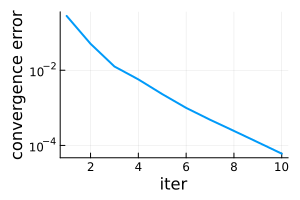

In [427]:
plot(cb.Δs, ylabel="convergence error", xlabel="iter", yaxis=:log10, 
    size=(300,200), label="")

In [432]:
# compute marginals
b_bp = beliefs(bp)
p_bp = [[bb[INFECTED] for bb in b] for b in b_bp]
p29_bp = [bb[INFECTED] for bb in b_bp[30]];

In [233]:
# instantiate Soft Margin sampler
sms = SoftMarginSampler(bp);

In [234]:
# draw samples
# re-run this cell (but not the one above!) to draw more samples and refine the estimate
nsamples_mc = 10^5
sample!(sms, nsamples_mc);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:06:23:41


In [235]:
# b_mc = marginals(sms)
# p29_mc = [bb[INFECTED] for bb in b_mc[29]];

In [396]:
# discard monte carlo runs with no infected at final time
# this is to compare with the results in the paper
ids = findall(!all(x[:,end] .== SUSCEPTIBLE) for x in sms.X)
Xnew = sms.X[ids]
wnew = sms.w[ids]
sms_new = SoftMarginSampler(bp, Xnew, wnew)
b_mc = marginals(sms_new)
p_mc = [[bb[INFECTED] for bb in b] for b in b_mc]
p29_mc = [bb[INFECTED] for bb in b_mc[30]];

In [237]:
pl = plot(xlabel="time", xticks=0:10:T, ylabel="\$P(x_{29}^t=I)\$", ylims=(-0.05,1), legend=:bottomright)
plot!(pl, 0:ΔT:T, p29_bp, m=:o, ms=2, label="MPBP")
plot!(pl, 0:ΔT:T, p29_mc, m=:x, ms=2, label="MC")
ylims = extrema((p29_bp[end], p29_mc[end].val)) .+ (-1, 1) .* 0.05
plot!(pl, xticks=T-20:4:T, ylims=ylims, xlims=(T-20,T),
    inset=(1, bbox(0.5, 0.3, 0.45, 0.4)), subplot=2)
plot!(pl[2], 0:ΔT:T, p29_bp, m=:o, ms=2, label="")
plot!(pl[2], 0:ΔT:T, p29_mc, m=:x, ms=2, label="");

In [238]:
pl_err = plot(xlabel="time", xticks=0:10:T) #, ylims=(-0.01,0.3))
plot!(pl_err, 0:ΔT:T, p29_bp.-p29_mc, label="", ylabel="L₁-error");

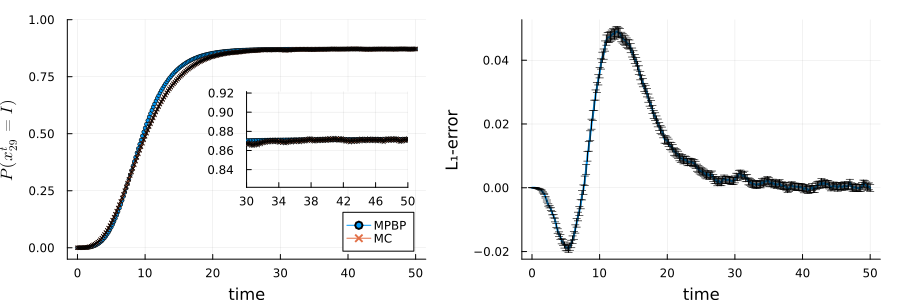

In [239]:
plot(pl, pl_err, size=(900,300), margin=3Plots.mm)

In [15]:
c = autocovariances(bp);

In [16]:
using ColorSchemes
function plot_autocovs(c, T; kw...)
    us = 10:10:T
    cg = cgrad(:matter, length(us), categorical=true)
    ylabel = "\$\\langle x_{29}^t x_{29}^{t+\\Delta t}\\rangle-" * 
        "\\langle x_{29}^t\\rangle\\langle x_{29}^{t+\\Delta t}\\rangle \$"
    xlabel = "\$\\Delta t \$"
    pl = plot(;xlabel, ylabel, legend=:outertopright, 
        title="SIS karate club. λ = $λ, ρ = $ρ")
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-1:1, c[(0:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j], m=:o, msc=cg[j]; kw...) 
    end
    pl
end  

plot_autocovs (generic function with 1 method)

In [17]:
c29 = map(x -> x > 0 ? x : NaN, c[29]);

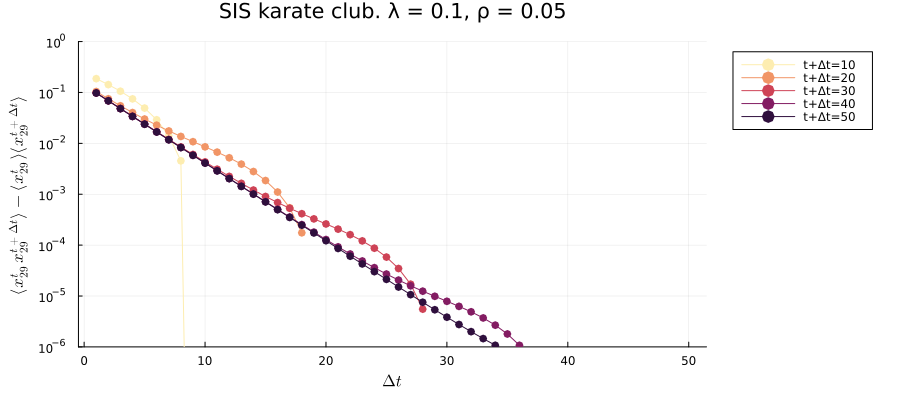

In [18]:
pl_autocov = plot_autocovs(c29, floor(Int, T/ΔT); yaxis=(:log10, (1e-6,1e-0)), 
    size=(900,400), margin=5Plots.mm)

In [43]:
jldsave("plot_data/sis_karate_club_network.jld2"; T, ΔT, p29_bp, p29_mc, c, λ, ρ, svd_trunc);

## Comparison with other methods

In [372]:
# # pair-based mean field
# function pbmf1!(r, ϕ, Tdisc, g, λ, ρ)
#     ProgressMeter.@showprogress for t in 2:Tdisc+1
#         for i in vertices(g)
#            r[t][i] = (1-ρ)*r[t-1][i] + λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i))
#         end
#         for (i, j, id) in edges(g)
#            ϕ[t][id] = (1-2ρ-λ)*ϕ[t-1][id] + ρ*r[t-1][i] - 
#                 λ*ϕ[t-1][id]*sum(r[t-1][k] for k in outneighbors(g,j) if j!=i) +
#                 λ*(1-r[t-1][i]-ϕ[t-1][id])*sum(r[t-1][k] for k in outneighbors(g,i) if j!=i)
#         end
#     end
#     nothing
# end

# cavity master equation
function cme!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])*sum(ϕ[t-1][idx(e)] for e in inedges(g, i); init=0.0)
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-ϕ[t-1][id])*λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=0.0)
        end
    end
    nothing
end

# dynamic message passing
function dmp!(r, ϕ, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])sum(ϕ[t-1][idx(e)] for e in inedges(g, i); init=0.0)
        end
        for (i, j, id) in edges(g)
           ϕ[t][id] = (1-ρ)*ϕ[t-1][id] + 
                (1-r[t-1][i])*λ*sum(ϕ[t-1][idx(e)] for e in inedges(g, i) if src(e)!=j; init=0.0)
        end
    end
    nothing
end

# individual based mean field
function ibmf!(r, Tdisc, g, λ, ρ)
    ProgressMeter.@showprogress for t in 2:Tdisc+1
        for i in vertices(g)
           r[t][i] = (1-ρ)*r[t-1][i] + λ*(1-r[t-1][i])sum(r[t-1][src(e)] for e in inedges(g, i); init=0.0)
        end
    end
    nothing
end

# # pair-based mean field
# function pbmf1!(r, z, Tdisc, g, λ, ρ)
#     fill!(ϕ, zeros(length(z[1])))
#     ProgressMeter.@showprogress for t in 2:Tdisc+1
#         for i in vertices(g)
#            r[t][i] = (1-ρ)*r[t-1][i] + λ*sum(r[t-1][src(e)]-z[t-1][idx(e)] for e in inedges(g, i))
#         end
#         for (i, j, id) in edges(g)
#            z[t][id] = (1-2(λ+ρ))*z[t-1][id] + 
#             λ*(sum(z[t-1][idx(e)]-z[t-1][id]*r[t-1][src(e)] for e in inedges(g,i)) +
#                sum(z[t-1][idx(e)]-z[t-1][id]*r[t-1][src(e)] for e in inedges(g,i)) +
#                z[t-1][id]*(r[t-1][i]+r[t-1][j]))
#             id == 18 && @show z[t][id]
#         end
#     end
#     nothing
# end

ibmf! (generic function with 1 method)

In [455]:
Δt = ΔT
Tdisc = floor(Int, T/Δt)

ϕ = [zeros(ne(bp.g)) for t in 0:Tdisc]
r = [zeros(nv(bp.g)) for t in 0:Tdisc]

r[1][1] = 1

for (i,j,id) in edges(g)
    ϕ[1][id] = r[1][i]*(1-r[1][j])
end

In [456]:
r_cme = deepcopy(r)
ϕ_cme = deepcopy(ϕ)
cme!(r_cme, ϕ_cme, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_cme = [[rt[i] for rt in r_cme] for i in 1:N];

In [457]:
r_dmp = deepcopy(r)
ϕ_dmp = deepcopy(ϕ)
dmp!(r_dmp, ϕ_dmp, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_dmp = [[rt[i] for rt in r_dmp] for i in 1:N];

In [458]:
# r_pbmf1 = deepcopy(r)
# z_pbmf1 = [zeros(ne(bp.g)) for t in 0:Tdisc]
# pbmf1!(r_pbmf1, z_pbmf1, Tdisc, bp.g, λ*Δt, ρ*Δt)
# p_pbmf1 = [[rt[i] for rt in r_pbmf1] for i in 1:N];

In [459]:
r_ibmf = deepcopy(r)
ibmf!(r_ibmf, Tdisc, bp.g, λ*Δt, ρ*Δt)
p_ibmf = [[rt[i] for rt in r_ibmf] for i in 1:N];

In [460]:
Plots.default(lw=2)

pl = plot(xlabel="time", xticks=0:10:T, ylabel="\$P(x_{29}^t=I)\$", ylims=(-0.05,1), legend=:bottomright)
plot!(pl, 0:ΔT:T, p29_bp, label="MPBP")
plot!(pl, 0:Δt:T, p_dmp[30], ls=:dash, label="rDMP")
plot!(pl, 0:Δt:T, p_cme[30], ls=:dashdot, label="CME")
plot!(pl, 0:Δt:T, p_ibmf[30], ls=:dashdotdot, label="IBMF")
# plot!(pl, 0:Δt:T, p_pbmf1[30], ls=:dashdotdot, label="PBMF1")
scatter!(pl, 0:ΔT:T, value.(p29_mc), m=:diamond, ms=2, label="MC", c=:black)

# ylims = extrema((p29_bp[end], p29_mc[end].val)) .+ (-1, 1) .* 0.05
ylims = (0.85,0.88)
plot!(pl, xticks=T-5:1:T, ylims=ylims, xlims=(T-5,T),
    inset=(1, bbox(0.5, 0.25, 0.45, 0.3)), subplot=2)
plot!(pl[2], 0:ΔT:T, p29_bp, label="")
plot!(pl[2], 0:Δt:T, p_dmp[30], ls=:dash, label="")
plot!(pl[2], 0:Δt:T, p_cme[30], ls=:dashdot, label="")
plot!(pl[2], 0:Δt:T, p_ibmf[30], ls=:dashdotdot, label="")
scatter!(pl[2], 0:ΔT:T, value.(p29_mc), m=:diamond, ms=3, label="", c=:black);

In [461]:
pl_err = plot(xlabel="time", xticks=0:10:T, ylabel="L₁-error")
plot!(pl_err, 0:ΔT:T, mean(abs.(p_bp[i] .- value.(p_mc[i])) for i in eachindex(p_bp)), label="MPBP")
plot!(pl_err, 0:ΔT:T, mean(abs.(p_dmp[i][1:Int(ΔT÷Δt):end] .- value.(p_mc[i])) for i in eachindex(p_dmp)),
        label="rDMP", ls=:dash)
plot!(pl_err, 0:ΔT:T, mean(abs.(p_cme[i][1:Int(ΔT÷Δt):end] .- value.(p_mc[i])) for i in eachindex(p_cme)), 
            label="CME", ls=:dashdot)
plot!(pl_err, 0:ΔT:T, mean(abs.(p_ibmf[i][1:Int(ΔT÷Δt):end] .- value.(p_mc[i])) for i in eachindex(p_ibmf)), 
                label="IBMF", ls=:dashdotdot);

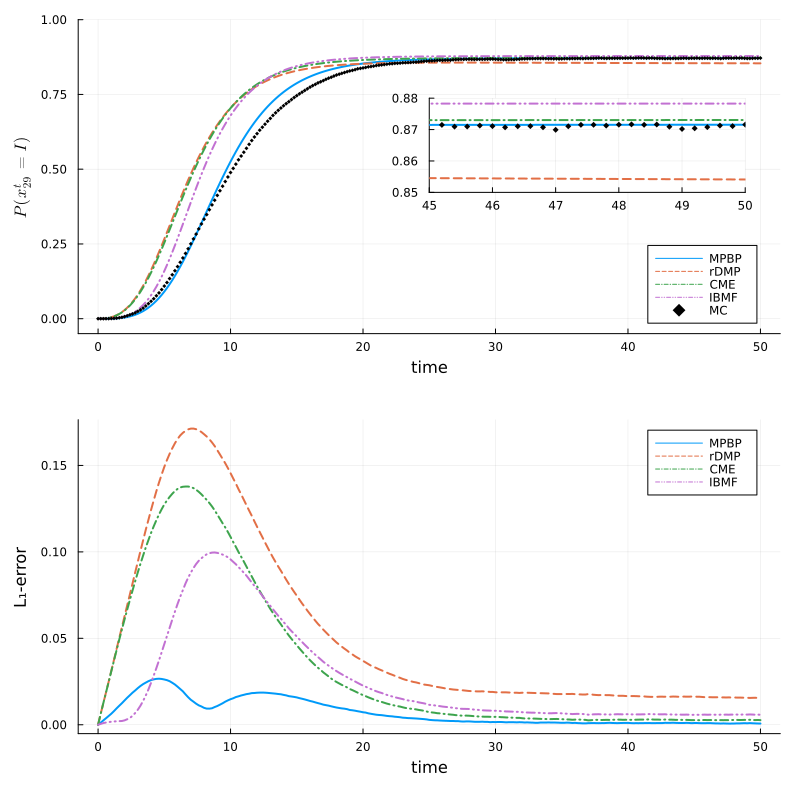

In [462]:
plot(pl, pl_err, size=(800,800), margin=3Plots.mm, layout=(2,1))

In [465]:
jldsave("plot_data/sis_karate_club_network.jld2"; T, ΔT, Δt, p_bp, p_mc, p_dmp, p_cme, p_ibmf, 
    λ, ρ, svd_trunc);